## Backward particle tracking through a steady-state flow field on an unstructured (DISV quadtree) grid

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 2 from the MODPATH 7 documentation.

In [1]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import numpy as np

Append to system path to include the common subdirectory

In [2]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [3]:
import config
from figspecs import USGSFigure

In [4]:
ggenexe="C:\\WrdApp\\gridgen.1.0.02\\bin\\gridgen.exe"
#mf6exe = os.path.abspath(config.mf6_exe)
# issue: temporary mf6exe path
mf6exe = "C:\\Users\\aprovost\\Documents\\ACTIVE\\modflow6\\bin\\mf6"
mp7exe = config.mp7_exe

Set figure properties specific to this problem

In [5]:
# figure sizes
figure_size_solo = (8.0, 8.0)
#figure_size_compare = (12.5, 4.5)
figure_size_compare = (15, 6)



Base simulation and model name and workspace

In [6]:
sim_name = "mp7-p02"
example_name = "ex-prt-" + sim_name

ws = config.base_ws

Simulation and model names, filenames, and workspaces

In [7]:
nm_mf6 = sim_name
nm_prt = sim_name + "_prt"
nm_mp7a = sim_name + "a"
nm_mp7b = sim_name + "b"

headfile = "{}.hds".format(nm_mf6)
headfile_bkwd = "{}.hds".format(nm_mf6 + "_bkwd")
budgetfile = "{}.cbb".format(nm_mf6)
budgetfile_bkwd = "{}.cbb".format(nm_mf6 + "_bkwd")
budgetfile_prt = "{}.cbb".format(nm_prt)

sim_ws = os.path.join(ws, example_name)
mf6gwf_ws = os.path.join(sim_ws, "mf6gwf")
mf6prt_ws = os.path.join(sim_ws, "mf6prt")
mp7_ws = os.path.join(sim_ws, "mp7")
ggen_ws = os.path.join(sim_ws, "gridgen")

Model units

In [8]:
length_units = "feet"
time_units = "days"

Time discretization parameters

In [9]:
tdis_rc = [(1000.0, 1, 1.0)]
nper = len(tdis_rc)

MODFLOW 6 flow model parameters

In [10]:
# Cell types by layer
icelltype = [1, 0, 0]

# Conductivities
k = [50.0, 0.01, 200.0]
k33 = [10.0, 0.01, 20.0]

# Well
# issue(flopyex): in the original flopy example, the well
#   coordinates were at the edge (not the center) of the cell,
#   but it apparently worked out anyway
wel_coords = (4718.45, 5281.25)
wel_q = -150000.0

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 318.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1

Create the DISV quadtree grid using Gridgen

In [11]:
from flopy.utils.gridgen import Gridgen

# Base grid parameters
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

# Create the base grid
ms = flopy.modflow.Modflow()
dis5 = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

# Create the Gridgen object
g = Gridgen(dis5, model_ws=ggen_ws, exe_name=ggenexe)

# Refine the grid
rf0shp = os.path.join(ggen_ws, "rf0")
xmin = 7 * delr
xmax = 12 * delr
ymin = 8 * delc
ymax = 13 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 1, range(nlay))

rf1shp = os.path.join(ggen_ws, "rf1")
xmin = 8 * delr
xmax = 11 * delr
ymin = 9 * delc
ymax = 12 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 2, range(nlay))

rf2shp = os.path.join(ggen_ws, "rf2")
xmin = 9 * delr
xmax = 10 * delr
ymin = 10 * delc
ymax = 11 * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 3, range(nlay))

# Build the refined grid
g.build(verbose=False)

Extract the Grid Properties

In [12]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops["ncpl"]
top = gridprops["top"]
botm = gridprops["botm"]
nvert = gridprops["nvert"]
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]

#### Plot the refinement areas and final grid

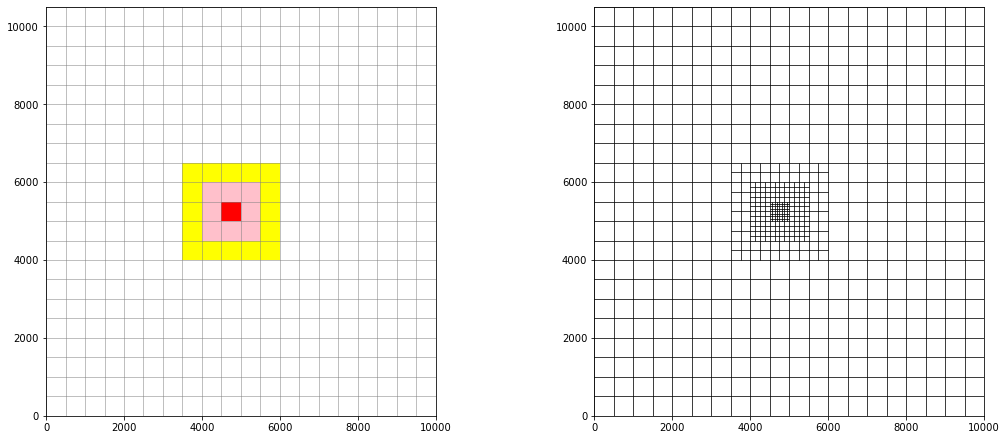

In [13]:
fig = plt.figure(figsize=figure_size_compare, constrained_layout=True)
ax = fig.add_subplot(1, 2, 1)
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid(lw=0.5)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor="yellow", edgecolor="none")
flopy.plot.plot_shapefile(rf1shp, ax=ax, facecolor="pink", edgecolor="none")
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor="red", edgecolor="none");

ax = fig.add_subplot(1, 2, 2, aspect="equal")
g.plot(ax, linewidth=0.5);

Data for the MODFLOW 6 well and river packages

In [14]:
# Well package
welcells = g.intersect([wel_coords], "point", 0)
welspd = [[(2, icpl), wel_q] for icpl in welcells["nodenumber"]]

# River package
riverline = [[[(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]]]
rivcells = g.intersect(riverline, "line", 0)
rivspd = [[(0, icpl), riv_h, riv_c, riv_z, riv_iface, riv_iflowface]
          for icpl in rivcells["nodenumber"]]

Shared MODFLOW 6 PRT and MODPATH 7 particle-tracking model parameters

In [15]:
# Porosity
porosity = 0.1

MODPATH 7 model parameters

Particle release point data for the MODFLOW 6 PRT particle-tracking model

In [16]:
from math import sqrt

welcellnode = welcells["nodenumber"][0]
xctr = cell2d[welcellnode][1]
yctr = cell2d[welcellnode][2]
vert0 = cell2d[welcellnode][4]
vert1 = cell2d[welcellnode][5]
x0 = vertices[vert0][1]
y0 = vertices[vert0][2]
x1 = vertices[vert1][1]
y1 = vertices[vert1][2]
dx = x1 - x0
dy = y1 - y0
delcell = sqrt(dx * dx + dy * dy)
delcellhalf = 0.5 * delcell

releasepts = {}

In [17]:
# Example 2A
releasepts['2A'] = []
zrpt = 0.5 * (botm[1][welcellnode] + botm[2][welcellnode])
npart_on_side = 4
delta = delcell / npart_on_side
baseoffset = 0.5 * (npart_on_side + 1) * delta
xbase = xctr - baseoffset
ybase = yctr - baseoffset
nrpt = -1
for idiv in range(npart_on_side):
    i = idiv + 1
    xrpt = xbase + i * delta
    yrpt = yctr + delcellhalf
    nrpt += 1
    rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
    releasepts['2A'].append(rpt)
    yrpt = yctr - delcellhalf
    nrpt += 1
    rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
    releasepts['2A'].append(rpt)
    yrpt = ybase + i * delta
    xrpt = xctr + delcellhalf
    nrpt += 1
    rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
    releasepts['2A'].append(rpt)
    xrpt = xctr - delcellhalf
    nrpt += 1
    rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
    releasepts['2A'].append(rpt)

In [18]:
# Example 2B
releasepts['2B'] = []
# 4x4 array of particles on top of well cell
zrpt = botm[1][welcellnode]
npart_on_side = 4
delta = delcell / npart_on_side
baseoffset = 0.5 * (npart_on_side + 1) * delta
xbase = xctr - baseoffset
ybase = yctr - baseoffset
nrpt = -1
for idivx in range(npart_on_side):
    ix = idivx + 1
    xrpt = xbase + ix * delta
    for idivy in range(npart_on_side):
        iy = idivy + 1
        yrpt = ybase + iy * delta
        nrpt += 1
        rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
        releasepts['2B'].append(rpt)
# 10x10 arrays of particles on the four sides of well cell
zwel = 0.5 * (botm[1][welcellnode] + botm[2][welcellnode])
npart_on_side = 10
delcellz = botm[1][welcellnode] - botm[2][welcellnode]
delta = delcell / npart_on_side
deltaz = delcellz / npart_on_side
baseoffset = 0.5 * (npart_on_side + 1) * delta
baseoffsetz = 0.5 * (npart_on_side + 1) * deltaz
xbase = xctr - baseoffset
ybase = yctr - baseoffset
zbase = zwel - baseoffsetz
for idivz in range(npart_on_side):
    iz = idivz + 1
    zrpt = zbase + iz * deltaz
    for idiv in range(npart_on_side):
        i = idiv + 1
        xrpt = xbase + i * delta
        yrpt = yctr + delcellhalf
        nrpt += 1
        rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
        releasepts['2B'].append(rpt)
        yrpt = yctr - delcellhalf
        nrpt += 1
        rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
        releasepts['2B'].append(rpt)
        yrpt = ybase + i * delta
        xrpt = xctr + delcellhalf
        nrpt += 1
        rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
        releasepts['2B'].append(rpt)
        xrpt = xctr - delcellhalf
        nrpt += 1
        rpt = [nrpt, (2, welcellnode), xrpt, yrpt, zrpt]
        releasepts['2B'].append(rpt)

Particle data for the MODPATH 7 model

In [19]:
# Example 2A
pcoord = np.array(
    [
        [0.000, 0.125, 0.500],
        [0.000, 0.375, 0.500],
        [0.000, 0.625, 0.500],
        [0.000, 0.875, 0.500],
        [1.000, 0.125, 0.500],
        [1.000, 0.375, 0.500],
        [1.000, 0.625, 0.500],
        [1.000, 0.875, 0.500],
        [0.125, 0.000, 0.500],
        [0.375, 0.000, 0.500],
        [0.625, 0.000, 0.500],
        [0.875, 0.000, 0.500],
        [0.125, 1.000, 0.500],
        [0.375, 1.000, 0.500],
        [0.625, 1.000, 0.500],
        [0.875, 1.000, 0.500],
    ]
)
nodew = ncpl * 2 + welcells["nodenumber"][0]
plocs = [nodew for i in range(pcoord.shape[0])]
pa = flopy.modpath.ParticleData(
    plocs,
    structured=False,
    localx=pcoord[:, 0],
    localy=pcoord[:, 1],
    localz=pcoord[:, 2],
    drape=0,
)

In [20]:
# Example 2B
facedata = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=10,
    horizontaldivisions1=10,
    verticaldivisions2=10,
    horizontaldivisions2=10,
    verticaldivisions3=10,
    horizontaldivisions3=10,
    verticaldivisions4=10,
    horizontaldivisions4=10,
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=4,
    columndivisions6=4,
)
pb = flopy.modpath.NodeParticleData(subdivisiondata=facedata, nodes=nodew)

Information used to extract and plot model results

In [21]:
# identify the boundary locations
ibd = np.zeros((ncpl), dtype=int)
ibd[welcells["nodenumber"]] = 1
ibd[rivcells["nodenumber"]] = 2
ibd = np.ma.masked_equal(ibd, 0)

# colormap for boundary locations
cmapbd = mpl.colors.ListedColormap(["r", "g",])

# time series point colors by layer
colors = ["green", "orange", "red"]

### Functions to build, write, run, and plot models

The following flopy simulation objects are returned:
  1. 
  2. 
  3. 
  4. 

In [22]:
def build_mf6gwf(example_name):
    print("Building gwf model...{}".format(example_name))

    # ====================================
    # Create the MODFLOW 6 flow simulation
    # ====================================
    
    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=nm_mf6, exe_name=mf6exe, version="mf6", sim_ws=mf6gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
    )

    # -------------------
    # Build the GWF model
    # -------------------

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=nm_mf6, model_nam_file="{}.nam".format(nm_mf6)
    )
    gwf.name_file.save_flows = True

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.ModflowGwfdisv(
        gwf,
        nlay=nlay,
        ncpl=ncpl,
        top=top,
        botm=botm,
        nvert=nvert,
        vertices=vertices,
        cell2d=cell2d,
    )

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=riv_h)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=[("xt3d")],
        icelltype=icelltype,
        k=k, k33=k33,
        save_saturation=True, save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.ModflowGwfrcha(
        gwf, recharge=rch,
        auxiliary=["iface", "iflowface"], aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    flopy.mf6.ModflowGwfwel(
        gwf, print_input=True, stress_period_data=welspd
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd,
        auxiliary=[("iface", "iflowface")])

    # Instantiate the MODFLOW 6 gwf output control package
    headfile = "{}.hds".format(nm_mf6)
    head_record = [headfile]
    budgetfile = "{}.cbb".format(nm_mf6)
    budget_record = [budgetfile]
    flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=budget_record,
        head_filerecord=head_record,
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    #---------------------------------------------------------------------
    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    #---------------------------------------------------------------------

    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        print_option="SUMMARY",
        complexity="SIMPLE",
        outer_dvclose=1.0e-5,
        outer_maximum=100,
        under_relaxation="NONE",
        inner_maximum=100,
        inner_dvclose=1.0e-6,
        rcloserecord=0.1,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=0.99,
    )
    sim.register_ims_package(ims, [gwf.name])

    #======================
    # Return the simulation
    #======================

    return sim

In [23]:
def build_mf6prt(example_name, idx):
    print("Building prt model...{}".format(example_name))

    # =================================================
    # Create the MODFLOW 6 particle-tracking simulation
    # ================================================
    
    # Instantiate the MODFLOW 6 simulation object
    simprt = flopy.mf6.MFSimulation(
        sim_name=nm_prt, version="mf6", exe_name=mf6exe, sim_ws=mf6prt_ws
    )

    # Create a time discretization for backward tracking;
    # since there is only a single period with a single time step,
    # the time discretization is the same backward as forward
    tdis_bkwd = tdis_rc

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.ModflowTdis(
        simprt, pname="tdis", time_units="DAYS", perioddata=tdis_bkwd, nper=len(tdis_bkwd)
    )

    # -------------------
    # Build the PRT model
    # -------------------

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        simprt, modelname=nm_prt, model_nam_file="{}.nam".format(nm_prt)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.ModflowGwfdisv(
        prt,
        nlay=nlay,
        ncpl=ncpl,
        top=top,
        botm=botm,
        nvert=nvert,
        vertices=vertices,
        cell2d=cell2d,
    )

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # kluge?
    if idx == 1:
        # Instantiate the MODFLOW 6 prt particle release point (prp) package
        # for example 2A
        nreleasepts1a = len(releasepts['2A'])
        pd = {0: ["FIRST"], 1: []}
        flopy.mf6.ModflowPrtprp(
            prt, pname="prp2a", filename="{}_2a.prp".format(nm_prt),
            nreleasepts=nreleasepts1a, packagedata=releasepts['2A'],
            perioddata=pd, 
        )
    else:
        # Instantiate the MODFLOW 6 prt particle release point (prp) package
        # for example 2B
        nreleasepts2b = len(releasepts['2B'])
        pd = {0: ["FIRST"], 1: []}
        flopy.mf6.ModflowPrtprp(
            prt, pname="prp2b", filename="{}_2b.prp".format(nm_prt),
            nreleasepts=nreleasepts2b, packagedata=releasepts['2B'],
            perioddata=pd,
        )

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile_prt = "{}.cbb".format(nm_prt)
    budget_record = [budgetfile_prt]
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    # using "time-reversed" budget and head files
    pd = [
        ("GWFHEAD", headfile_bkwd),
        ("GWFBUDGET", budgetfile_bkwd),
    ]
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    #--------------------------------------------------------------------
    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    #--------------------------------------------------------------------

    # issue(flopy): using IMS until mfsimulation.py is updated for EMS by Scott
    # issue(mf6): code is kluged to create EMS if first model in IMS is a PRT
    ems = flopy.mf6.ModflowIms(
        simprt, pname="ems",
        outer_maximum=100,
        filename="{}.ems".format(nm_prt),
    )
    simprt.register_ims_package(ems, [prt.name])

    #======================
    # Return the simulation
    #======================

    return simprt

In [24]:
def build_mp7(example_name, idx):
    print("Building mp7 models...{}".format(example_name))

    # Get the gwf model
    s = flopy.mf6.modflow.MFSimulation.load('s', sim_ws=mf6gwf_ws)
    gwf = s.get_model(nm_mf6)
    
    # kluge
    mp7a = None
    mp7b = None
    
    if idx == 1:

        # ========================================================
        # Create MODPATH 7 pathline and timeseries simulation (2A)
        # ========================================================

        # Instantiate the MODPATH 7 simulation object
        bfile = os.path.join("..\\..\\", mf6gwf_ws, budgetfile)
        hfile = os.path.join("..\\..\\", mf6gwf_ws, headfile)
        mp7a = flopy.modpath.Modpath7(
            modelname=nm_mp7a, flowmodel=gwf, exe_name=mp7exe, model_ws=mp7_ws,
            budgetfilename=bfile, headfilename=hfile
        )

        # Instantiate the MODPATH 7 basic data
        flopy.modpath.Modpath7Bas(mp7a, porosity=porosity)

        # Instantiate the MODPATH 7 particle group
        fpth = nm_mp7a + ".sloc"
        pga = flopy.modpath.ParticleGroup(
            particlegroupname="BACKWARD2A", particledata=pa, filename=fpth
        )

        # Instantiate the MODPATH 7 simulation data
        flopy.modpath.Modpath7Sim(
            mp7a,
            simulationtype="combined",
            trackingdirection="backward",
            weaksinkoption="pass_through",
            weaksourceoption="pass_through",
            referencetime=0.0,
            stoptimeoption="extend",
            timepointdata=[500, 1000.0],
            particlegroups=pga,
        )

    else:

        # =========================================
        # Create MODPATH 7 endpoint simulation (2B)
        # =========================================

        # Instantiate the MODPATH 7 simulation object
        bfile = os.path.join("..\\..\\", mf6gwf_ws, budgetfile)
        hfile = os.path.join("..\\..\\", mf6gwf_ws, headfile)
        mp7b = flopy.modpath.Modpath7(
            modelname=nm_mp7b, flowmodel=gwf, exe_name=mp7exe, model_ws=mp7_ws,
            budgetfilename=bfile, headfilename=hfile
        )

        # Instantiate the MODPATH 7 basic data
        flopy.modpath.Modpath7Bas(mp7b, porosity=porosity)

        # Instantiate the MODPATH 7 particle group
        fpth = nm_mp7b + ".sloc"
        pgb = flopy.modpath.ParticleGroupNodeTemplate(
            particlegroupname="BACKWARD2B", particledata=pb, filename=fpth
        )

        # Instantiate the MODPATH 7 simulation data
        flopy.modpath.Modpath7Sim(
            mp7b,
            simulationtype="endpoint",
            trackingdirection="backward",
            weaksinkoption="pass_through",
            weaksourceoption="pass_through",
            referencetime=0.0,
            stoptimeoption="extend",
            particlegroups=pgb,
        )
    
    #======================
    # Return the simulation
    #======================

    return mp7a, mp7b

In [25]:
def build_model(example_name, idx):

    sim = None
    simprt = None
    mp7a = None
    mp7b = None
    if idx == 0:
        sim = build_mf6gwf(example_name)
    else:
        simprt = build_mf6prt(example_name, idx)
        mp7a, mp7b = build_mp7(example_name, idx)

    # ======================
    # Return the simulations
    # ======================
    
    return sim, simprt, mp7a, mp7b

Function to write model files

In [26]:
def write_model(sim, simprt, mp7a, mp7b, idx, silent=True):
    if config.writeModel:
        if idx == 0:
            sim.write_simulation(silent=silent)
        elif idx == 1:
            simprt.write_simulation(silent=silent)
            mp7a.write_input()
        else:
            simprt.write_simulation(silent=silent)
            mp7b.write_input()
    return

Function to run the models; True is returned if the model runs successfully

In [27]:
def reverse_budgetfile():

    import flopy.utils.binaryfile as bf

    # Create a reverse budget file for backward tracking;
    # since the flow budget file has only a single period
    # with a single time step, really only need to negate
    # the flows, but implementing the general procedure
    # anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load budget file and get number of records
    fpth = os.path.join(mf6gwf_ws, budgetfile)
    cbb = bf.CellBudgetFile(fpth)
    nrecords = cbb.get_nrecords()
    # Header array formats
    dt1 = np.dtype(
        [
            ("kstp", np.int32),
            ("kper", np.int32),
            ("text", "S16"),
            ("ndim1", np.int32),
            ("ndim2", np.int32),
            ("ndim3", np.int32),
            ("imeth", np.int32),
            ("delt", np.float64),
            ("pertim", np.float64),
            ("totim", np.float64),
        ]
    )
    dt2 = np.dtype(
        [
            ("text1id1", "S16"),
            ("text1id2", "S16"),
            ("text2id1", "S16"),
            ("text2id2", "S16"),
        ]
    )
    # Open backward budget file
    fpth = os.path.join(mf6prt_ws, budgetfile_bkwd)
    with open(fpth, "wb") as fbin:
        # Loop over budget file records in reverse order
        for idx in range(nrecords-1, -1 ,-1):
            # Load header array
            header = cbb.recordarray[idx]
            # Replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header['kstp'] - 1, header['kper'] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header['kstp'], header['kper']) = (kstpb + 1, kperb + 1)
            # Replace totim and pertim in the header array with their
            # backward counterparts
            header['totim'] = tsimtotal - header['totim']
            perlen = tdis_rc[kper][0]
            header['pertim'] = perlen - header['pertim']
            # Write main header information to backward budget file
            h = header[['kstp','kper','text',
                         'ncol','nrow','nlay',
                         'imeth','delt','pertim','totim',
                        ]]
            # Note: much of the code below is based on binary_file_writer.py
            h = np.array(h, dtype=dt1)
            h.tofile(fbin)
            if header['imeth'] == 6:
                # Write additional header information to the backward budget file
                h = header[['modelnam','paknam','modelnam2','paknam2',]]
                h = np.array(h, dtype=dt2)
                h.tofile(fbin)
                # Load data
                data = cbb.get_data(idx)[0]
                data = np.array(data)
                # Negate flows
                data['q'] = -data['q']
                # Write ndat (number of floating point columns)
                colnames = data.dtype.names
                ndat = len(colnames) - 2
                dt = np.dtype([("ndat", np.int32)])
                h = np.array([(ndat,)], dtype=dt)
                h.tofile(fbin)
                # Write auxiliary column names
                naux = ndat - 1
                if naux > 0:
                    auxtxt = ["{:16}".format(colname) for colname in colnames[3:]]
                    auxtxt = tuple(auxtxt)
                    dt = np.dtype([(colname, "S16") for colname in colnames[3:]])
                    h = np.array(auxtxt, dtype=dt)
                    h.tofile(fbin)
                # Write nlist
                nlist = data.shape[0]
                dt = np.dtype([("nlist", np.int32)])
                h = np.array([(nlist,)], dtype=dt)
                h.tofile(fbin)
            elif header['imeth'] == 1:
                # Load data
                data = cbb.get_data(idx)[0][0][0]
                data = np.array(data, dtype=np.float64)
                # Negate flows
                data = -data
            else:
                sys.exit("not expecting imeth " + header['imeth'])
            # Write data
            data.tofile(fbin)
    # Close backward budget file
    fbin.close()

    return

In [28]:
def reverse_headfile():

    import flopy.utils.binaryfile as bf

    # Create a reverse head file for backward tracking;
    # since the head file has only a single period
    # with a single time step, not really necessary
    # to reverse it, but implementing the general
    # procedure anyway
    # issue(flopy): would be good to have a standard script to do this

    # Get maximum period number and total simulation time
    kpermx = nper - 1
    tsimtotal = 0.
    for tpd in tdis_rc:
        tsimtotal += tpd[0]

    # Load head file and get number of records
    fpth = os.path.join(mf6gwf_ws, headfile)
    hds = bf.HeadFile(fpth)
    # issue(flopy): HeadFile doesn't appear to have a get_records
    #   method like CellBudgetFile does
    #nrecords = hds.get_nrecords()
    nrecords = hds.recordarray.shape[0]
    # Header array formats
    dt = np.dtype(
        [
                ("kstp", np.int32),
                ("kper", np.int32),
                ("pertim", np.float64),
                ("totim", np.float64),
                ("text", "S16"),
                ("ncol", np.int32),
                ("nrow", np.int32),
                ("ilay", np.int32),
        ]
    )
    # Open backward head file
    fpth = os.path.join(mf6prt_ws, headfile_bkwd)
    with open(fpth, "wb") as fbin:
        # loop over head file records in reverse order
        for idx in range(nrecords-1, -1 ,-1):
            # load header array
            header = hds.recordarray[idx]
            # replace kstp and kper in the header array with their
            # backward countparts
            (kstp, kper) = (header['kstp'] - 1, header['kper'] - 1)
            kstpmx = tdis_rc[kper][1] - 1
            kstpb = kstpmx - kstp
            kperb = kpermx - kper
            (header['kstp'], header['kper']) = (kstpb + 1, kperb + 1)
            # replace totim and pertim in the header array with their
            # backward counterparts
            header['totim'] = tsimtotal - header['totim']
            perlen = tdis_rc[kper][0]
            header['pertim'] = perlen - header['pertim']
            # write header information to the backward head file
            h = np.array(header, dtype=dt)
            h.tofile(fbin)
            # load data
            data = hds.get_data(idx=idx)[0][0]
            data = np.array(data, dtype=np.float64)
            # write data
            data.tofile(fbin)
    # Close backward head file
    fbin.close()
    
    return

In [29]:
# temporary utility function
def copy_grb_tdis():

    import shutil

    fname = os.path.join(nm_mf6 + ".disv.grb")
    filemf6 = os.path.join(mf6gwf_ws, fname)
    filemp7 = os.path.join(mp7_ws, fname)
    cp = shutil.copyfile(filemf6, filemp7)

    fname = os.path.join(nm_mf6 + ".tdis")
    filemf6 = os.path.join(mf6gwf_ws, fname)
    filemp7 = os.path.join(mp7_ws, fname)
    cp = shutil.copyfile(filemf6, filemp7)

    return

In [30]:
@config.timeit
def run_model(sim, simprt, mp7a, mp7b, idx, silent=True):
    success = True
    if config.runModel:
        if idx == 0:
            # Run MODFLOW 6 flow simulation
            success_run = False
            success_run, buff = sim.run_simulation(silent=silent)
            if not success_run:
                print(buff)
                success = success_run
        else:
            # kluge? (one prt run)
            # Process budget and head files for backward tracking
            reverse_budgetfile()
            reverse_headfile()
            # Run MODFLOW 6 PRT particle-tracking simulation
            success_run = False
            success_run, buff = simprt.run_simulation(silent=silent)
            if not success_run:
                print(buff)
                success = success_run
            # issue(flopy): has only flopy-determined paths/names for the GRB and TDIS files,
            #   for both mf6 output and mp7 input, so here they are being copied over from the
            #   mf6 folder to the mp7 folder using a temporary utility function
            copy_grb_tdis()
            if idx == 1:
                # Run MODPATH 7 simulation 1A
                success_run = False
                success_run, buff = mp7a.run_model(silent=silent)
                if not success_run:
                    print(buff)
                    success = success_run
            else:
                # Run MODPATH 7 simulation 1B
                success_run = False
                success_run, buff = mp7b.run_model(silent=silent)
                if not success_run:
                    print(buff)
                    success = success_run
    return success

In [31]:
# Utility function for reading and storing MODFLOW 6 PRT pathlines
# for this problem
# issue(flopy): need general routine for loading prt pathline data
def load_mf6pathlines(cbb):

    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    mf6pathlines = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        pdict = {}
        # For each time, read and parse particle data written by the prp
        # and add it to a dictionary keyed on a particle identifier consisting
        # of release point number and release time
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                kp = node // ncpl
                # issue(mf6): particle ids not assigned yet in mf6
                pathpoint = (xp, yp, zp, ttrack, kp, 0)
                key = (irpt, trelease)
                # Note that repeat locations written for terminated particles
                # are not filtered out here, though they could be
                if key not in pdict:
                    pdict[key] = [pathpoint]
                else:
                    pdict[key].append(pathpoint)
        # Reformat into mf6pathlines dictionary
        mf6pathlines[subprob] = []
        for key in pdict:
            path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
            mf6pathlines[subprob].append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

In [32]:
# Utility function for reading and storing MODFLOW 6 PRT endpoint data
# for this problem
# issue(flopy): need general routine for loading prt endpoint data
def load_mf6endpointdata(cbb):

    dtype={'names':['time0','time',
                    'node0','k0','x0','y0','z0',
                    'node','k','x','y','z',
                    'zone'],
           'formats':['<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    mf6endpointdata = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        edict = {}
        # For each time, read and parse particle data written by the prp
        # and store it in a dictionary keyed on a particle identifier consisting
        # of release point number and release time; later data overwrite earlier
        # data for the same key, ultimately resulting in the endpoint being stored;
        # alternatively, could read backwards in time, but would still need to
        # deal with repeat locations for terminated particles
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                key = (irpt, trelease)
                # to facilitate meaningful travel times, do not include the repeat locations
                # that are written for a terminated particle
                if (key not in edict) or \
                node != edict[key][7] or xp != edict[key][9] or \
                yp != edict[key][10] or zp != edict[key][11]:
                    rpt = releasepts[subprob][irpt]
                    (krls, icpl) = rpt[1]
                    noderls = krls * ncpl + icpl
                    xrls = rpt[2]
                    yrls = rpt[3]
                    zrls = rpt[4]
                    kp = (node - 1) // ncpl
                    # issue(mf6): zone info not stored with particle locations,
                    #   so hardwiring it to 0 in this problem
                    zone = 0
                    # issue(mf6): particle ids not assigned yet in mf6
                    edict[key] = (trelease, ttrack,
                                  noderls, krls, xrls, yrls, zrls,
                                  node, kp, xp, yp, zp,
                                  zone)
        # Reformat into mf6endpointdata dictionary
        mf6endpointdata[subprob] = []
        for key in edict:
            mf6endpointdata[subprob].append(edict[key])
        mf6endpointdata[subprob] = np.rec.array(mf6endpointdata[subprob], dtype=dtype)

    # Return mf6endpointdata
    return mf6endpointdata

In [33]:
# Utility function for reading and storing MODPATH 7 pathlines
# for this problem
def load_mp7pathlines(plf):

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7pathlines = {}
    for dest in ['well', 'river']:
        pdata = plf.get_destination_pathline_data(nodes[dest], to_recarray=True)
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7pathlines[(subprob, dest)] = np.array([point for point in pdata
                                                      if point['particlegroup'] == pgidx],
                                                     dtype=pdata.dtype)

    # Return mp7pathlines
    return mp7pathlines

In [34]:
# Utility function for reading and storing MODPATH 7 endpoint data
# for this problem
def load_mp7endpointdata(epf):

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7endpointdata = {}
    for dest in ['well', 'river']:
        epd = epf.get_destination_endpoint_data(dest_cells=nodes[dest])
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7endpointdata[(subprob, dest)] = np.array([point for point in epd
                                                         if point['particlegroup'] == pgidx],
                                                         dtype=epd.dtype)

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ['1A', '1B']:
        mp7endpointdata[(subprob, 'all')] = np.concatenate((mp7endpointdata[(subprob, 'well')],
                                                            mp7endpointdata[(subprob, 'river')]))

    # Return mp7endpointdata
    return mp7endpointdata

In [35]:
# Utility function for plotting pathlines and time series
# points colored by layer
def plot_pathlines_and_timeseries(ax, mg, pathlines, timeseries, subprob, plottitle):

    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
    mm.plot_grid(lw=0.5)
    v = mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
    mm.plot_pathline(pathlines, layer="all", color="blue", lw=0.75)
    # issue(mf6): no way to output time series in prt
    if timeseries != None:
#        for k in range(nlay):
#            mm.plot_timeseries(timeseries, layer=k, marker="o", lw=0, color=colors[k]);
        for k in range(nlay-1, -1 ,-1):
            mm.plot_timeseries(timeseries, layer=k, marker="o", lw=0, color=colors[k]);
    ax.set_title(plottitle, fontsize=12)

    return

In [36]:
def plot_results(sim, simprt, mp7a, mp7b, idx):
    
    import flopy.utils.binaryfile as bf

    # Get model grid
    fname = os.path.join(mf6gwf_ws, nm_mf6 + ".disv.grb")
    grd = flopy.mf6.utils.MfGrdFile(fname, verbose=False)
    mg = grd.modelgrid

    if idx == 0:

        # --------------------------------------
        # Subset of the model cells and vertices
        # --------------------------------------

        # Zoom area
        xmin, xmax = 2000, 4500
        ymin, ymax = 5400, 7500

        # Initialize plot
        fs = USGSFigure(figure_type="map", verbose=False)
        fig = plt.figure(figsize=figure_size_solo)
        fig.tight_layout()
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
        v = mm.plot_grid(lw=0.5, edgecolor="black")
        t = ax.set_title("Model cells and vertices (one-based)\n", fontsize=14)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        # Vertices
        verts = mg.verts
        ax.plot(verts[:, 0], verts[:, 1], "bo")
        for i in range(ncpl):
            x, y = verts[i, 0], verts[i, 1]
            if xmin <= x <= xmax and ymin <= y <= ymax:
                ax.annotate(str(i + 1), verts[i, :], color="b")

        # Cell centers
        xc, yc = mg.get_xcellcenters_for_layer(0), mg.get_ycellcenters_for_layer(0)
        for i in range(ncpl):
            x, y = xc[i], yc[i]
            ax.plot(x, y, "ro")
            if xmin <= x <= xmax and ymin <= y <= ymax:
                ax.annotate(str(i + 1), (x, y), color="r")

        plt.show()

        # ==================
        # Boundary locations
        # ==================
        
#        fig = plt.figure(figsize=figure_size_solo, constrained_layout=True)
        fs = USGSFigure(figure_type="map", verbose=False)
        fig = plt.figure(figsize=figure_size_solo)
        fig.tight_layout()
        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
        mm.plot_grid(lw=0.5)
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
        pc = pmv.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
        t = ax.set_title("Boundary Conditions\n", fontsize=14)
        
        plt.show()

        # ============
        # Head results
        # ============

        # Import simulated head values from the binary head file
        fname = os.path.join(mf6gwf_ws, nm_mf6 + ".hds")
        hdobj = flopy.utils.HeadFile(fname)
        head = hdobj.get_data()

        # Prepare a plot of heads in layer 3
        ilay = 2
        cint = 0.25
#        fig = plt.figure(figsize=figure_size_solo, constrained_layout=True)
        fs = USGSFigure(figure_type="map", verbose=False)
        fig2 = plt.figure(figsize=figure_size_solo)
        fig2.tight_layout()
        ax = fig2.add_subplot(1, 1, 1, aspect="equal")
        mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax, layer=ilay)
        mm.plot_grid(lw=0.5)
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
        pc = mm.plot_array(head[:, 0, :], cmap="jet", edgecolor="black")
        hmin = head[ilay, 0, :].min()
        hmax = head[ilay, 0, :].max()
        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[:, 0, :], colors="white", levels=levels)
        plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)
        cb = plt.colorbar(pc, shrink=0.5)
        t = ax.set_title(
            "Head in model Layer {}; hmin={:6.2f}, hmax={:6.2f}\n".format(ilay + 1, hmin, hmax),
            fontsize=14
        )
        
        plt.show()

    else:

        # MODFLOW 6 PRT budget file
        fpth = os.path.join(mf6prt_ws, budgetfile_prt)
        cbb = bf.CellBudgetFile(fpth)

        # Load MODFLOW 6 PRT pathlines
        mf6pathlines = load_mf6pathlines(cbb)

        # Load MODFLOW 6 PRT endpoint data
        mf6endpointdata = load_mf6endpointdata(cbb)

        # Load MODPATH 7 pathlines
        fpth = os.path.join(mp7_ws, nm_mp7a + ".mppth")
        plf = flopy.utils.PathlineFile(fpth)
        mp7pathlines = plf.get_alldata()

        # Load MODPATH 7 timeseries
        fpth = os.path.join(mp7_ws, nm_mp7a + ".mppth")
        tsf = flopy.utils.PathlineFile(fpth)
        mp7timeseries = tsf.get_alldata()

        # Load MODPATH 7 endpoint data
        fpth = os.path.join(mp7_ws, nm_mp7b + ".mpend")
        epf = flopy.utils.EndpointFile(fpth)
        mp7endpointdata = epf.get_alldata()

        if idx == 1:

            # ==========
            # Example 2A
            # ==========

            # ------------------------------------------------
            # Pathlines and time series point colored by layer
            # ------------------------------------------------

            # Initialize plot
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size_compare)
            plt.suptitle(t='Example 2A - Pathlines and time series points tracked backward from well',
                         fontsize=14)
            axes = axes.flatten()

            # MODFLOW 6 PRT
            ax = axes[0]
            # issue(mf6): no way to output time series
            plot_pathlines_and_timeseries(ax, mg, mf6pathlines['2A'], None, '2A', 'MODFLOW 6 PRT')

            # MODPATH 7
            ax = axes[1]
            plot_pathlines_and_timeseries(ax, mg, mp7pathlines, mp7timeseries, '2A', 'MODPATH 7')

            # Save figure
            if config.plotSave:
                fpth = os.path.join(
                    "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
                )
                fig.savefig(fpth)

        else:

            # ==========
            # Example 2B
            # ==========

            # -------------------------------------------
            # Endpoints colored by travel time to capture
            # -------------------------------------------

            # Initialize plot
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size_compare)
            plt.suptitle(t='Example 2B - Endpoints of particle paths tracked backward from well',
                         fontsize=14)
            axes = axes.flatten()

            # MODFLOW 6 PRT
            ax = axes[0]
            ax.set_xlim(0, Lx)
            ax.set_ylim(0, Ly)
            mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
            mm.plot_grid(lw=0.5)
            v = mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
            mm.plot_endpoint(mf6endpointdata['2B'], direction="ending", colorbar=True, shrink=0.25)
            ax.set_title('MODFLOW 6 PRT', fontsize=12)

            # MODPATH 7
            ax = axes[1]
            ax.set_xlim(0, Lx)
            ax.set_ylim(0, Ly)
            mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
            mm.plot_grid(lw=0.5)
            v = mm.plot_array(ibd, cmap=cmapbd, edgecolor="gray")
            mm.plot_endpoint(mp7endpointdata, direction="ending", colorbar=True, shrink=0.25)
            # issue(flopy): the center "dot" looks to be in a slightly different location
            # in the two plots -- true even if you plot the very same endpoint array in both plots
            ax.set_title('MODPATH 7', fontsize=12)

            # Save figure
            if config.plotSave:
                fpth = os.path.join(
                    "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
                )
                fig.savefig(fpth)
        
    return

Function that wraps all of the steps for each scenario.

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.

In [37]:
def scenario(idx, silent=True):
    sim, simprt, mp7a, mp7b = build_model(example_name, idx)
    write_model(sim, simprt, mp7a, mp7b, idx, silent=silent)
    success = run_model(sim, simprt, mp7a, mp7b, idx, silent=silent)
    if success:
        plot_results(sim, simprt, mp7a, mp7b, idx)

### MODFLOW 6 flow simulation

Building gwf model...ex-prt-mp7-p02
run_model  388.49 ms


findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


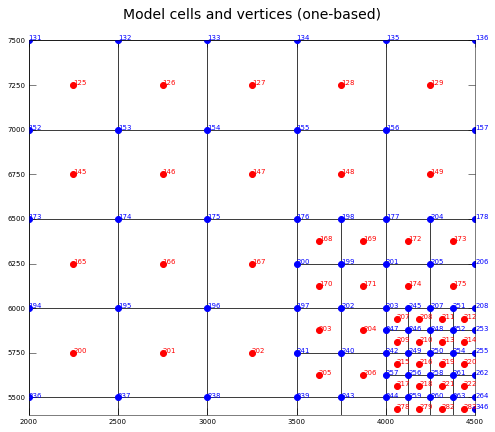

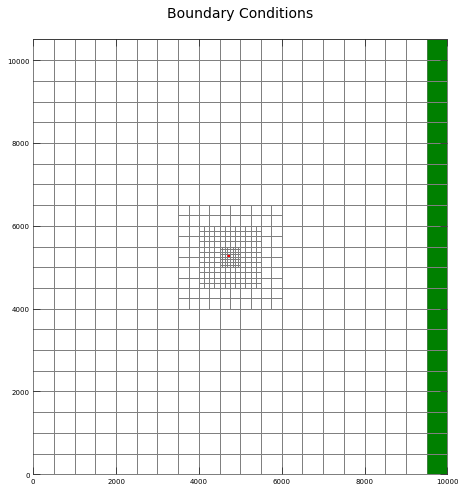

findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


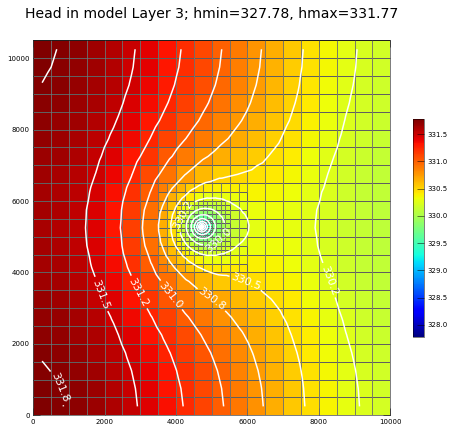

In [38]:
scenario(0)

Building prt model...ex-prt-mp7-p02
Building mp7 models...ex-prt-mp7-p02
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package wel...
    loading package riv...
    loading package oc...
  loading ims package mp7-p02...
run_model  1,475.79 ms


findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


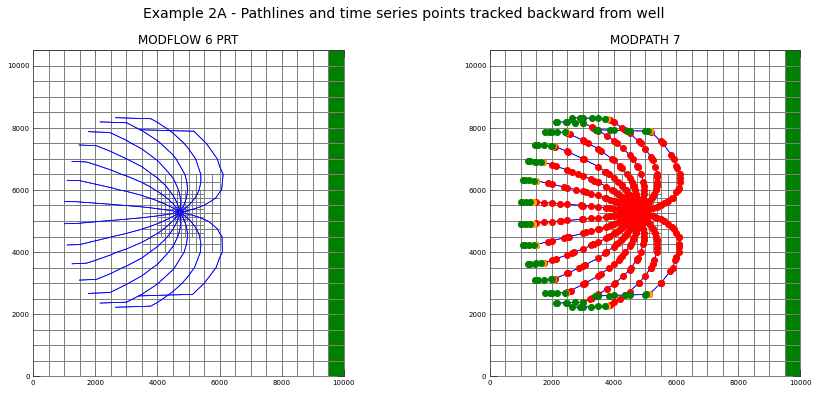

In [39]:
scenario(1)

Building prt model...ex-prt-mp7-p02
Building mp7 models...ex-prt-mp7-p02
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package wel...
    loading package riv...
    loading package oc...
  loading ims package mp7-p02...
run_model  1,388.37 ms


findfont: Font family ['Arial Narrow'] not found. Falling back to DejaVu Sans.


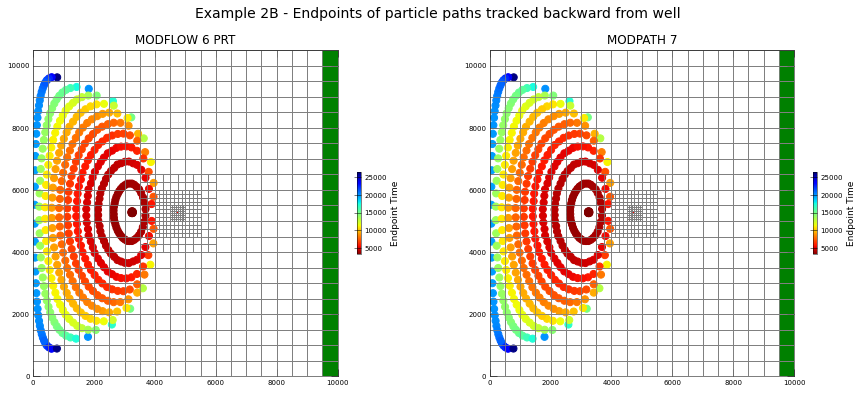

In [40]:
scenario(2)